In [1]:
import zipfile
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import imageio
import cv2

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# open zip file
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/Springboard - Capstone 3/rawData.zip', 'r')

# create folder with raw data
zip_ref.extractall('/content/BloodCellData')
zip_ref.close()

In [4]:
# Train Data Directory
Train_datadir = '../content/BloodCellData/Data/Train'
Test_datadir = '../content/BloodCellData/Data/Test'

print("Train Directory Folders:", os.listdir(Train_datadir))
print("Test Directory Folders:", os.listdir(Test_datadir))

Train Directory Folders: ['LYMPHOCYTE', 'MONOCYTE', 'EOSINOPHIL', 'NEUTROPHIL']
Test Directory Folders: ['LYMPHOCYTE', 'MONOCYTE', 'EOSINOPHIL', 'NEUTROPHIL']


In [5]:
# Image Size
image_width = 320
image_height = 240

# Split the data to training
train_images = tf.keras.utils.image_dataset_from_directory(
    Train_datadir,
    label_mode='int',
    validation_split=0.2,
    subset="training",
    seed=123,
    shuffle=True,
    image_size=(image_height, image_width))

# Split the data to validation
validation_images = tf.keras.utils.image_dataset_from_directory(
    Train_datadir,
    label_mode='int',
    validation_split=0.2,
    subset="validation",
    seed=123,
    shuffle=True,
    image_size=(image_height, image_width))

Found 9957 files belonging to 4 classes.
Using 7966 files for training.
Found 9957 files belonging to 4 classes.
Using 1991 files for validation.


In [6]:
class_names = train_images.class_names
print(class_names)

['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']


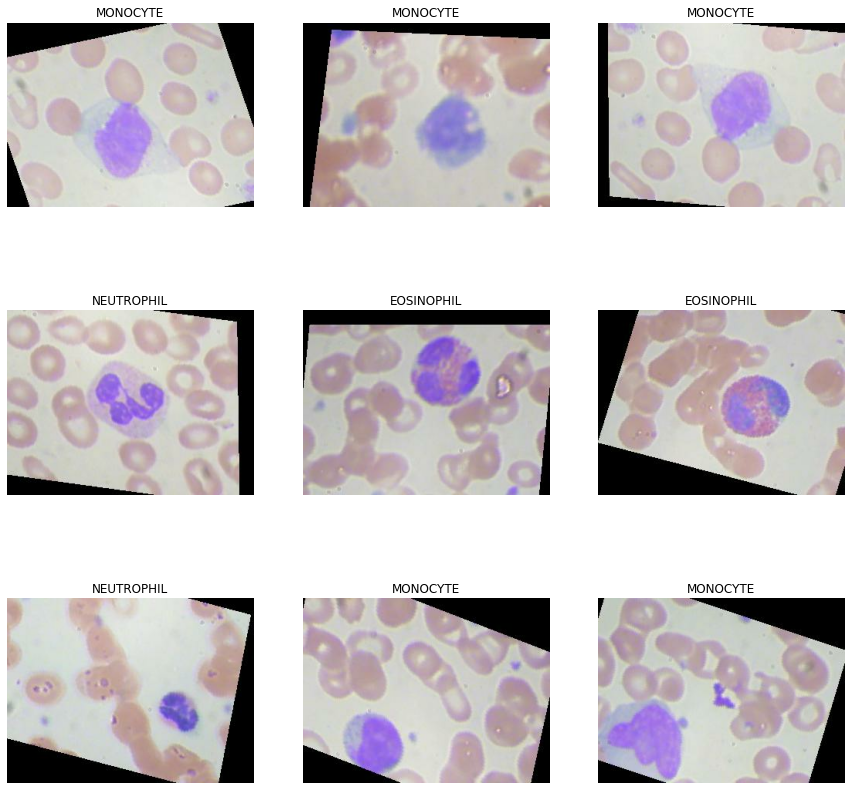

In [7]:
# Display images from train_image split
plt.figure(figsize=(15, 15))

for images, labels in train_images.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
# Display shape of the batches from the train_image split
for image_batch, labels_batch in train_images:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 240, 320, 3)
(32,)


In [64]:
# Using transfer learning base model Xception
base_model = tf.keras.applications.Xception(
    weights='imagenet',
    input_shape=(240, 320, 3),
    include_top=False
)

# Freezing base_model
base_model.trainable = False

# Input variable
inputs = tf.keras.Input(shape=(240, 320, 3))

# Rescales using Xception preprocessing to (-1,1)
x = tf.keras.applications.xception.preprocess_input(inputs)

# Build base model
x = base_model(x, training=False)

x = tf.keras.layers.MaxPooling2D(2,2)(x)
x = tf.keras.layers.Dropout(.20)(x)
x = tf.keras.layers.Conv2D(128,(2,2),activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2,2)(x)
x = tf.keras.layers.Dropout(.20)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.20)(x)
x = tf.keras.layers.Dense(4, activation='softmax')(x)

model = tf.keras.Model(inputs, x)

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 240, 320, 3)]     0         
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 240, 320, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_3 (TFOpLam  (None, 240, 320, 3)      0         
 bda)                                                            
                                                                 
 xception (Functional)       (None, 8, 10, 2048)       20861480  
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 4, 5, 2048)       0         
 2D)                                                             
                                                           

In [65]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [66]:
epochs = 25
history = model.fit(train_images, epochs=epochs, validation_data=validation_images)

Epoch 1/20
249/249 [==============================] - 73s 285ms/step - loss: 1.2054 - accuracy: 0.4549 - val_loss: 0.8986 - val_accuracy: 0.6118
Epoch 2/20
249/249 [==============================] - 72s 287ms/step - loss: 0.8452 - accuracy: 0.6430 - val_loss: 0.7193 - val_accuracy: 0.7057
Epoch 3/20
249/249 [==============================] - 72s 289ms/step - loss: 0.6815 - accuracy: 0.7189 - val_loss: 0.5488 - val_accuracy: 0.7820
Epoch 4/20
249/249 [==============================] - 71s 285ms/step - loss: 0.5891 - accuracy: 0.7571 - val_loss: 0.5099 - val_accuracy: 0.7951
Epoch 5/20
249/249 [==============================] - 72s 288ms/step - loss: 0.5189 - accuracy: 0.7881 - val_loss: 0.5142 - val_accuracy: 0.7870
Epoch 6/20
249/249 [==============================] - 71s 283ms/step - loss: 0.4631 - accuracy: 0.8145 - val_loss: 0.5224 - val_accuracy: 0.7850
Epoch 7/20
249/249 [==============================] - 71s 284ms/step - loss: 0.4231 - accuracy: 0.8343 - val_loss: 0.4587 - val_ac

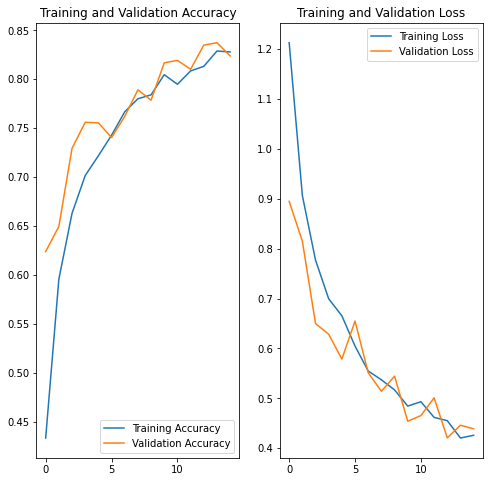

In [59]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
test_images = tf.keras.utils.image_dataset_from_directory(
    Test_datadir,
    label_mode='int',
    image_size=(image_height, image_width))

Found 2487 files belonging to 4 classes.


In [60]:
loss, accuracy = model.evaluate(test_images)
print("Loss:", loss)
print("Accuracy:", accuracy)

78/78 [==============================] - 17s 214ms/step - loss: 1.5538 - accuracy: 0.5147


In [61]:
Prediction = model.predict(test_images)
Prediction = Prediction.argmax(axis=1)

In [62]:
print(Prediction)

[1 3 3 ... 0 1 3]


In [30]:
labelList = []

for batch in range(len(test_images)):
  for img, label in test_images.take(batch):
    labelList.append(label)

In [40]:
list(labelList[1])

[<tf.Tensor: shape=(), dtype=int32, numpy=1>,
 <tf.Tensor: shape=(), dtype=int32, numpy=0>,
 <tf.Tensor: shape=(), dtype=int32, numpy=2>,
 <tf.Tensor: shape=(), dtype=int32, numpy=0>,
 <tf.Tensor: shape=(), dtype=int32, numpy=0>,
 <tf.Tensor: shape=(), dtype=int32, numpy=3>,
 <tf.Tensor: shape=(), dtype=int32, numpy=3>,
 <tf.Tensor: shape=(), dtype=int32, numpy=0>,
 <tf.Tensor: shape=(), dtype=int32, numpy=3>,
 <tf.Tensor: shape=(), dtype=int32, numpy=2>,
 <tf.Tensor: shape=(), dtype=int32, numpy=0>,
 <tf.Tensor: shape=(), dtype=int32, numpy=0>,
 <tf.Tensor: shape=(), dtype=int32, numpy=2>,
 <tf.Tensor: shape=(), dtype=int32, numpy=3>,
 <tf.Tensor: shape=(), dtype=int32, numpy=3>,
 <tf.Tensor: shape=(), dtype=int32, numpy=2>,
 <tf.Tensor: shape=(), dtype=int32, numpy=2>,
 <tf.Tensor: shape=(), dtype=int32, numpy=2>,
 <tf.Tensor: shape=(), dtype=int32, numpy=3>,
 <tf.Tensor: shape=(), dtype=int32, numpy=3>,
 <tf.Tensor: shape=(), dtype=int32, numpy=1>,
 <tf.Tensor: shape=(), dtype=int32

In [37]:
flat_list[:5]

[<tf.Tensor: shape=(), dtype=int32, numpy=1>,
 <tf.Tensor: shape=(), dtype=int32, numpy=1>,
 <tf.Tensor: shape=(), dtype=int32, numpy=1>,
 <tf.Tensor: shape=(), dtype=int32, numpy=2>,
 <tf.Tensor: shape=(), dtype=int32, numpy=3>]

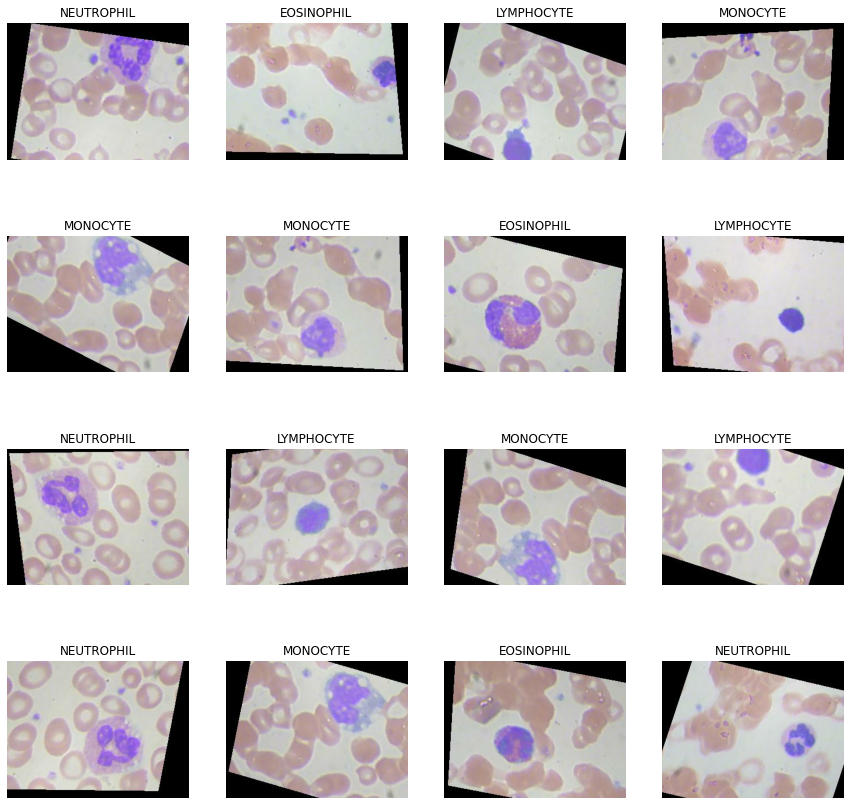

In [47]:
# Display images from train_image split
plt.figure(figsize=(15, 15))

for images, labels in test_images.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")